In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [3]:
def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.9.1


Import Data

In [4]:
dataset = nlp.load_dataset('emotion')

Using custom data configuration default


In [5]:
dataset

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
def get_tweets(data):
    tweets = [x['text'] for x in data]
    labels = [x['label'] for x in data] #extracting tweets and labels from data
    return tweets, labels

In [8]:
tweets, labels = get_tweets(train)

tweets[2], labels[2]

('im grabbing a minute to post i feel greedy wrong', 'anger')

Tokenizing the tweets
words to numbers so that you can train the model

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [11]:
tokenizer.texts_to_sequences([tweets[0]])


[[2, 139, 3, 679]]

In [12]:
tweets[0]

'i didnt feel humiliated'

Padding and Truncating Sequences

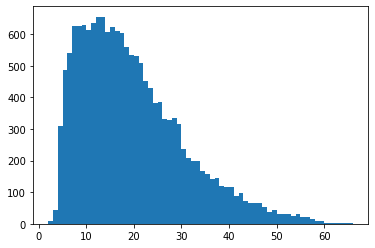

In [13]:
lengths = [len(t.split(' ')) for t in tweets]  ##checking length of tweets
plt.hist(lengths, bins= len(set(lengths)))
plt.show()

In [14]:
max_len = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len)
    return padded

In [16]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [19]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

Preparing Labels

In [20]:
classes = set(labels)
print(classes)

{'love', 'anger', 'sadness', 'joy', 'surprise', 'fear'}


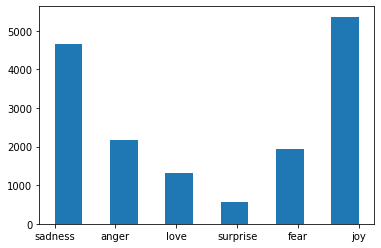

In [21]:
plt.hist(labels, bins=11)
plt.show()

In [23]:
class_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [24]:
class_to_index

{'love': 0, 'anger': 1, 'sadness': 2, 'joy': 3, 'surprise': 4, 'fear': 5}

In [25]:
index_to_class

{0: 'love', 1: 'anger', 2: 'sadness', 3: 'joy', 4: 'surprise', 5: 'fear'}

In [26]:
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

In [27]:
train_labels = names_to_ids(labels)
print(train_labels[0])

2


Creating the Model

In [28]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
        tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(

    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


Training the Model

In [30]:
val_tweets, val_labels = get_tweets(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [31]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 2)

In [32]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 65s 83ms/step - loss: 1.2898 - accuracy: 0.4786 - val_loss: 0.8264 - val_accuracy: 0.6815
Epoch 2/20
500/500 [==============================] - 40s 79ms/step - loss: 0.6588 - accuracy: 0.7293 - val_loss: 0.6832 - val_accuracy: 0.7430
Epoch 3/20
500/500 [==============================] - 40s 80ms/step - loss: 0.4870 - accuracy: 0.8072 - val_loss: 0.6074 - val_accuracy: 0.7770
Epoch 4/20
500/500 [==============================] - 39s 79ms/step - loss: 0.3402 - accuracy: 0.8798 - val_loss: 0.5319 - val_accuracy: 0.8430
Epoch 5/20
500/500 [==============================] - 45s 90ms/step - loss: 0.2488 - accuracy: 0.9202 - val_loss: 0.4703 - val_accuracy: 0.8635
Epoch 6/20
500/500 [==============================] - 64s 129ms/step - loss: 0.1864 - accuracy: 0.9419 - val_loss: 0.4369 - val_accuracy: 0.8725
Epoch 7/20
500/500 [==============================] - 63s 125ms/step - loss: 0.1379 - accuracy: 0.9575 - val_loss: 0.4536 - val_accurac

Model Evaluation

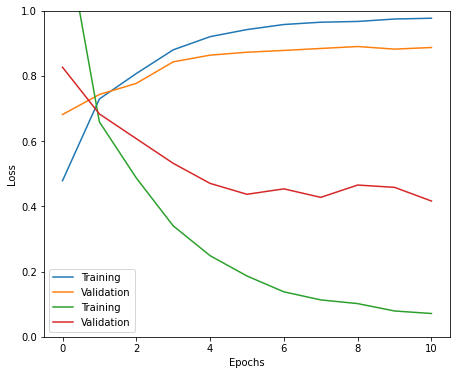

In [34]:
show_history(h)  ##visualizing training history

In [35]:
test_tweets, test_labels = get_tweets(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [36]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 2s 30ms/step - loss: 0.4134 - accuracy: 0.8855


In [50]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: i feel like im super rich kinda like when i could drink goldschlager haha
Emotion: joy
1/1 [==============================] - 0s 64ms/step
Predicted Emotion: joy


In [56]:
preds = model.predict(test_seq)

63/63 [==============================] - 2s 30ms/step
